<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#数据预处理" data-toc-modified-id="数据预处理-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>数据预处理</a></span><ul class="toc-item"><li><span><a href="#时间戳处理" data-toc-modified-id="时间戳处理-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>时间戳处理</a></span></li><li><span><a href="#补全与计算VWAP" data-toc-modified-id="补全与计算VWAP-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>补全与计算VWAP</a></span></li></ul></li><li><span><a href="#模型的选择与介绍" data-toc-modified-id="模型的选择与介绍-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>模型的选择与介绍</a></span><ul class="toc-item"><li><span><a href="#LSTM-模型" data-toc-modified-id="LSTM-模型-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LSTM 模型</a></span></li></ul></li><li><span><a href="#代码结构" data-toc-modified-id="代码结构-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>代码结构</a></span><ul class="toc-item"><li><span><a href="#数据预处理(prepare_data_for_supervised.py)" data-toc-modified-id="数据预处理(prepare_data_for_supervised.py)-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>数据预处理(<code>prepare_data_for_supervised.py</code>)</a></span></li></ul></li><li><span><a href="#训练与预测结果" data-toc-modified-id="训练与预测结果-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>训练与预测结果</a></span><ul class="toc-item"><li><span><a href="#LSTM-模型" data-toc-modified-id="LSTM-模型-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>LSTM 模型</a></span></li></ul></li></ul></div>

# 期货商品时间序列数据预测

> 1. prcVwap.csv 中的数据是37个商品期货的vwap数据，5分钟一条。   
这个数组的shape是（125083,37）。37列每一列对应一个商品期货的品种，
具体的品种顺序，参照allSymbol.csv。125083行，每一行都是一个timeStamp。
日期参照tradeDate5min.csv。分钟参照hourMinute.csv。   

>2. 要求利用这些数据，实现机器学习算法。 vol.csv是volume的数据。格式如前。利用T交易日前所有数据对T交易日的return（T日的vwap/T-1日的vwap）进行预测。

> 要求写明分析过程和数据处理的Python代码。以及选用某个算法的理由。   

---------------------

这是一个**监督学习**的问题： 给定$P(x_i, t< t_0)$, $V(x_i, t < t_0)$, 预测$R(x_i, t_0)$。   
$$
R(x_i, T) = \frac{VWAP(x_i, T)}{VWAP(x_i, T-1)},\\
VWAP(x_i, T) = \frac{\int_{t}dt\, P(x_i, t)V(x_i, t)}{\int_{t}dt\,V(x_i, t)}
$$
离散时间情况下，积分换为求和。

## 数据预处理   

### 时间戳处理   
将`tradeDate5min_.csv` 与`hourMinute_.csv`的时间信息合并起来，组成TimeIndex, `prcVwap_.csv` 和 `volume_.csv`的index都改为TimeIndex.   
  - 在 `data_preprocessing.py` 中， `combineTimestamp(date, hourMin)` 完成Hour，Minute识别组合
  - 注意时分的数字数可能是 $850.0\rightarrow 08:50$, $55.0 \rightarrow 00:55$, 采用识别数字按照四位数左补0；
  - 注意到分钟有60分的出现，先换算为秒之后用`timedelta`加在年月日上就行。 

### 补全与计算VWAP

1 计算每天的VWAP值,   

 对于给定的期货商品$x_i, i = 0,1,...,36$, 某T日的VWAP为，
  $$
  VWAP(x_i, T) = \frac{\sum_{t} P(x_i, t)V(x_i, t)}{\sum_{t}V(x_i, t)} ,
  $$
  其中$V(x_i, t)$为T日内每五分钟数据的交易量, $P(x_i, t)$为对应vwap值。

2 将包含以日为时间单位的VWAP数据导出到`./newdata/vwap_for_days_.csv`, 同时也保存了对应的`volume`数据--`./newdata/volume_for_days_.csv`.

3 考虑到缺失数据，某天没有交易的数据空缺，对vwap数据采用向前填充或者向后填充,`fillna(method=ffill` or `bfill`), 优先向前填充。商品的交易量volume空缺的一律填充为0， 这是假设未交易日价格不会偏离其前后太远，上述填充不会影响到其他大时间尺度的VWAP的计算结果。

4 将每个商品的补全后的vwap值，volume以及return输出到单独的csv文件，（`./newdata/goods/`）

(2552, 37)
(2552, 37)
[0, 1, 2]


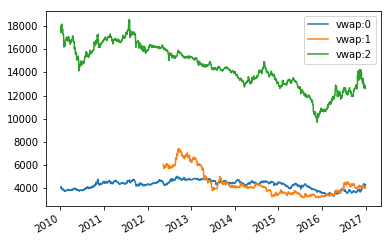

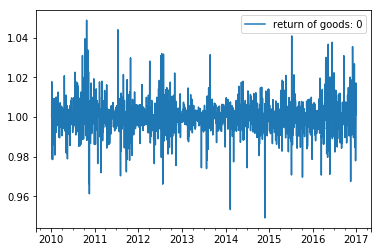

In [2]:
# %load data_preprocessing.py
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

import os


def get_vwap_volume_product(vwap_df, volume_df):
    '''
     Calculate the full data VWAP values
    Input: two DataFrame with timestamp
    '''
    vwap_all =  (vwap_df*volume_df)

    return vwap_all

def get_days_sum_data(df, day):

    return df[str(pd.Period(day, freq = 'D'))].sum()


def get_vwap_for_days(start, end, vwap_all, volume_df):
    '''
    Calculate vwap value in timespan from start to end.
    -----
    start, end: timestamp or datetime objects
    return: vwap of all products for a single day if end=None
    '''
    if end is None:
        # calculate the whole day vwap summation
        return np.array(
        vwap_all[str(pd.Period(start, freq = 'D'))].sum()
        /volume_df[str(pd.Period(start, freq = 'D'))].sum()
        )
    else:
        # given time span vwap calculation
        return np.array(vwap_all[str(start):str(end)].sum()/volume_df[str(start):str(end)].sum())

def combineTimestamp(date, hourMin):
    """ Calculate the timestamp from given tradeDate, hourMinute file"""
    # match hour and minute
    # note that minute data has 60 which is large than 59
    str_hM = str(hourMin).split('.')[0]
    str_hM = (4-len(str_hM))*'0' + str_hM

    timeStamp = datetime.strptime(str(date), '%Y%m%d.0')+pd.to_timedelta(float(str_hM[0:2])*3600+float(str_hM[2:])*60, unit='s')

    return timeStamp

def cleanData():
    Date = pd.read_csv('./data/tradeDate5min_.csv', index_col=0)
    hourMinute = pd.read_csv('./data/hourMinute_.csv', index_col=0)
    prcVwap = pd.read_csv('./data/prcVwap_.csv', index_col=0)
    volume = pd.read_csv('./data/volume_.csv', index_col=0)
    # 将时间戳合并生成TimeIndex
    timeStampList = [combineTimestamp(x,y) for x,y in zip(Date['0'].values, hourMinute['0'].values)]
    timeIndex = pd.DatetimeIndex(timeStampList)

    # 重新定义index为时间戳
    prcVwap_timeIndex = prcVwap.rename(index = dict(zip(prcVwap.index, timeIndex)))
    volume_timeIndex = volume.rename(index = dict(zip(volume.index, timeIndex)))

    #print('prcVwap-shape: ', prcVwap_timeIndex.shape)
    #print('Volume-shape: ', volume_timeIndex.shape)

    # save data
    if not os.path.exists('./newdata'):
        os.makedirs('./newdata')
        prcVwap_timeIndex.to_csv('./newdata/timeIndex_prcVwap_.csv')
        volume_timeIndex.to_csv('./newdata/timeIndex_volume_.csv')
        print('Save to csv !')

def split_df_into_goods_with_return():
    '''
    Split the DataFrame into small csv for each goods!

    '''
    path = './newdata/goods'
    if not os.path.exists(path):
        os.makedirs(path)
        if os.path.exists('./newdata/vwap_for_days_.csv') and os.path.exists('./newdata/volume_for_days_.csv'):
            vwap_for_days = pd.read_csv('./newdata/vwap_for_days_.csv', index_col=0, parse_dates = True)
            volume_days = pd.read_csv('./newdata/volume_for_days_.csv', index_col=0, parse_dates = True)

            for id in range(37):
                # note the fillna assumption
                df_vwap = pd.DataFrame(vwap_for_days[str(id)]).fillna(method = 'ffill').fillna(method = 'bfill')
                df_vol = pd.DataFrame(volume_days[str(id)]).fillna(0.0) # fill zeros for volume

                goods_df = pd.concat([df_vwap, df_vol], axis=1)#.dropna()
                goods_df.columns = [str(id)+'_vwap', str(id)+'_vol']
                # add ‘return’ column
                goods_df[str(id)+'_return'] = goods_df[str(id)+'_vwap'].rolling(2).apply(lambda x: x[1]/x[0])

                # Note that we fill the nan with 1.0 for the return value
                goods_df.fillna(1.0).to_csv(str(path + '/'+ str(id)+'_goods.csv'))
        else:
            print('No vwap_for_days_.csv !')
            return None

def data_preprocessing():
    '''

    '''

    if not os.path.exists('./newdata'):
        cleanData()

    if os.path.exists('./newdata/timeIndex_prcVwap_.csv'):
    # read data, REMEMBER the parse_dates !
        prcVwap = pd.read_csv('./newdata/timeIndex_prcVwap_.csv', index_col=0, parse_dates = True)
        volume = pd.read_csv('./newdata/timeIndex_volume_.csv', index_col=0, parse_dates = True)
    else:
        print('No csv data !')

    if not os.path.exists('./newdata/vwap_for_days_.csv'):
        # make copy and fill in zeros
        vwap_data = prcVwap.copy()#.fillna(0.0)
        vol_data = volume.copy()#.fillna(0.0)

        vwap_all = get_vwap_volume_product(vwap_df=vwap_data, volume_df=vol_data)
        # determine days range
        time_index = vwap_data.index
        start_day = str(pd.Period(time_index[0], freq = 'D'))
        end_day = str(pd.Period(time_index[-1], freq = 'D'))

        #print(vwap_all[start_day])

        day_list = pd.date_range(start_day, end_day, freq='D')

        vwap_for_days = pd.DataFrame([get_vwap_for_days(day, None, vwap_all, vol_data) for day in day_list], index = day_list)
        volume_days = pd.DataFrame([get_days_sum_data(vol_data, day) for day in day_list], index = day_list)

        print(vwap_for_days.shape)
        #print(vwap_for_days.head())
        vwap_for_days.to_csv('./newdata/vwap_for_days_.csv')
        volume_days.to_csv('./newdata/volume_for_days_.csv')

    # split_df_into_goods with return values
    split_df_into_goods_with_return()
#=================================

if __name__ == '__main__':
    data_preprocessing()

    vwap_for_days = pd.read_csv('./newdata/vwap_for_days_.csv', index_col=0, parse_dates = True)
    volume_days = pd.read_csv('./newdata/volume_for_days_.csv', index_col=0, parse_dates = True)

    print(vwap_for_days.shape)
    print(volume_days.shape)

    # plot the vwap for every products
    groups = list(range(0,3))
    print(groups)
    plt.figure()
    i = 1
    for group in groups:
        #plt.subplot(len(groups), 1, i)
        vwap_for_days[str(group)].dropna().plot(label='vwap:'+str(group), sharex=True)
        i += 1
    plt.legend()
    plt.show()

    id = 0
    goods = pd.read_csv('./newdata/goods/'+str(id)+'_goods.csv', index_col=0, parse_dates = True)
    goods[str(id)+'_return'].plot(style='-',label='return of goods: '+str(id))
    plt.legend()
    plt.show()

## 模型的选择与介绍   

### LSTM 模型  

考虑到这是一个时间序列的预测问题，需要训练的算法对历史数据具有**记忆**功能，传统的机器学习算法不具有这个能力，调研发现深度学习算法中循环神经网络（RNN）具有这个能力，尤其是LSTM模型（Long Short-Term Memory）在很多, 模型的概念参考这两篇博客[Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)、[零基础入门深度学习(6) - 长短时记忆网络(LSTM)](https://zybuluo.com/hanbingtao/note/581764)。  RNN已经在各种领域尤其是自然语言文本处理、语音识别、机器翻译等方面得到了[极大的应用](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)。

LSTM是RNN的一种变体，RNN由于梯度消失的原因只能有短期记忆，LSTM网络通过精妙的门控制将短期记忆与长期记忆结合起来，并且一定程度上解决了梯度消失的问题。

下面将尝试使用基于python的高级API深度学习库`Keras`中LSTM模型来进行时间序列的预测。

**以其中一个商品：0 为例**

## 代码结构

### 数据预处理(`prepare_data_for_supervised.py`)  

这里的预处理指将数据处理成监督学习的数据形式，包括训练数据及其标签，测试数据及其标签。

In [3]:
# %load prepare_data_for_supervised.py
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def prepare_for_supervised(dataF, n_in=1, n_out=1, dropnan=True):
    """
    dataF: original DataFrame
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    returns: Pandas DataFrame for supervised learning.
    """

    n_vars = dataF.shape[1]

    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dataF.shift(i))
        names += [(str(col)+'(t-%d)' % i) for col in dataF.columns]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dataF.shift(-i))
        if i == 0:
            names += [(str(col)+'(t)') for col in dataF.columns]
        else:
            names += [(str(col)+'(t+%d)' % i) for col in dataF.columns]
    # put it all together
    df = pd.concat(cols, axis=1)
    df.columns = names
    # drop rows with NaN values
    if dropnan:
        df.dropna(inplace=True)
    return df

def scaled_dataframe(df):
    # normalize features
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled = scaler.fit_transform(df.values)
    scaled_df = pd.DataFrame(scaled, index = df.index, columns=df.columns)
    # need to return the scaler for recover the data!
    return scaled_df, scaler

def inverse_scale(scaler, X, y, n_features):
    # invert scaling for prediction
    # 这里随便给n_features-1列放在前面做 inverse_transform，其实只要最后一列对就行
    inv_y = np.concatenate((X[:,-n_features:-1], y.reshape(-1,1)), axis=1)
    inv_y = scaler.inverse_transform(inv_y)[:, -1]
    return inv_y


def split_train_test(sup_df_values, n_days, n_features, split_ratio=0.67):
    '''
    sup_df_values: DataFrame, only last column is the label y(t)
    return: train_X, train_y   test_X, test_y          [np.array]
    '''
    M, N = sup_df_values.shape
    train_size = int(M*split_ratio)

    train = sup_df_values[:train_size, :]
    test = sup_df_values[train_size:, :]

    n_obs = n_days*n_features
    train_X, train_y = train[:, :n_obs], train[:, -1]
    test_X, test_y = test[:, :n_obs], test[:, -1]

    return train_X, train_y, test_X, test_y


if __name__ == '__main__':
    values = pd.DataFrame(np.random.randn(10,2), columns=list('ab'))
    data = prepare_for_supervised(values, n_in=2)
    print(data, '\n')
    print('Initial df：\n', values)

     a(t-2)    b(t-2)    a(t-1)    b(t-1)      a(t)      b(t)
2 -0.316922  0.080760 -0.386883  1.175663 -1.117480  0.167060
3 -0.386883  1.175663 -1.117480  0.167060  0.858882 -1.038988
4 -1.117480  0.167060  0.858882 -1.038988  0.871943  0.597398
5  0.858882 -1.038988  0.871943  0.597398  0.137084 -0.516167
6  0.871943  0.597398  0.137084 -0.516167 -1.848202  0.146915
7  0.137084 -0.516167 -1.848202  0.146915  0.285325 -0.808532
8 -1.848202  0.146915  0.285325 -0.808532 -0.091771 -0.333629
9  0.285325 -0.808532 -0.091771 -0.333629 -0.783979 -0.688124 

Initial df：
           a         b
0 -0.316922  0.080760
1 -0.386883  1.175663
2 -1.117480  0.167060
3  0.858882 -1.038988
4  0.871943  0.597398
5  0.137084 -0.516167
6 -1.848202  0.146915
7  0.285325 -0.808532
8 -0.091771 -0.333629
9 -0.783979 -0.688124


将（t-1）时刻及其之前的数据作为训练t时刻的feature值，t时刻的return作为数据的label。

## 训练与预测结果

### LSTM 模型    

/home/papageno/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(2040, 1, 3) (2040,) (511, 1, 3) (511,)
Train on 2040 samples, validate on 511 samples
Epoch 1/30
 - 0s - loss: 0.4567 - val_loss: 0.4052
Epoch 2/30
 - 0s - loss: 0.3319 - val_loss: 0.2961
Epoch 3/30
 - 0s - loss: 0.1905 - val_loss: 0.1686
Epoch 4/30
 - 0s - loss: 0.0700 - val_loss: 0.0877
Epoch 5/30
 - 0s - loss: 0.0637 - val_loss: 0.1012
Epoch 6/30
 - 0s - loss: 0.0557 - val_loss: 0.1045
Epoch 7/30
 - 0s - loss: 0.0565 - val_loss: 0.0961
Epoch 8/30
 - 0s - loss: 0.0547 - val_loss: 0.0963
Epoch 9/30
 - 0s - loss: 0.0540 - val_loss: 0.0927
Epoch 10/30
 - 0s - loss: 0.0533 - val_loss: 0.0903
Epoch 11/30
 - 0s - loss: 0.0523 - val_loss: 0.0879
Epoch 12/30
 - 0s - loss: 0.0517 - val_loss: 0.0853
Epoch 13/30
 - 0s - loss: 0.0509 - val_loss: 0.0826
Epoch 14/30
 - 0s - loss: 0.0501 - val_loss: 0.0798
Epoch 15/30
 - 0s - loss: 0.0494 - val_loss: 0.0771
Epoch 16/30
 - 0s - loss: 0.0486 - val_loss: 0.0745
Epoch 17/30
 - 0s - loss: 0.0479 - val_loss: 0.0721
Epoch 18/30
 - 0s - loss: 0.0471 - val

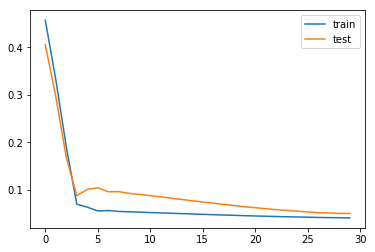

Test RMSE: 0.0080


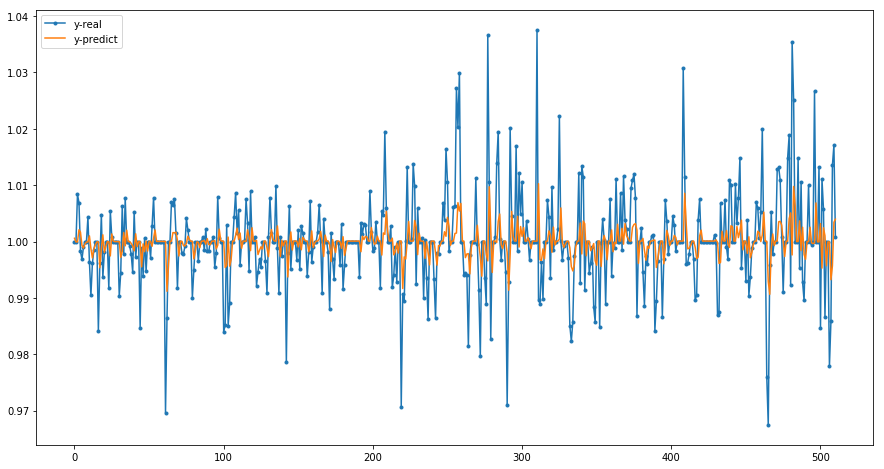

In [4]:
# %load keras_lstm.py
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from datetime import datetime

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import os

from data_preprocessing import data_preprocessing
import prepare_data_for_supervised as pdfs

#-----------------------
# original data for vwap
if not os.path.exists('./newdata'):
    data_preprocessing()

df0 = pd.read_csv('./newdata/goods/0_goods.csv', index_col=0, parse_dates = True)

#df0['0_return'] = np.log(df0['0_return'].values)

# normalization
scaled_df, scaler = pdfs.scaled_dataframe(df0)
# more parameters
n_days, n_features = 1, 3
        # vwap, volume, return
# dataset for supervised learning
dataset_sup = pdfs.prepare_for_supervised(scaled_df, n_days, 1)
# the last feature is the label ! history label also is a feature.

train_X, train_y, test_X, test_y = pdfs.split_train_test(dataset_sup.values, n_days, n_features, split_ratio=0.8)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# LSTM network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
# hidden layer neurons
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=150, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make a prediction
yhat = model.predict(test_X)

test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
# inverse_scale
inv_yhat = pdfs.inverse_scale(scaler, test_X, yhat, n_features)
# inverse scaling for test_y
inv_y = pdfs.inverse_scale(scaler, test_X, test_y, n_features)

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.4f' % rmse)

#print(yhat, test_y)
plt.figure(figsize=(15,8))
plt.plot(list(range(len(inv_y))), inv_y,'.-',label='y-real')
plt.plot(list(range(len(inv_yhat))), inv_yhat,'-', label='y-predict')
plt.legend()
plt.show()

我们将数据集的前2040天的数据作为训练集，后面511天的数据作为预测：
  - 上面第一张图给出的是LSTM模型在训练集和测试集上的平均绝对值误差随着训练次数增加的变化；  
  - 第二张图给出的是：商品0的return值（后面的511天）的预测值和其真实值之间对比系。
  
 ---------------------

- 调参过程中发现使用更长的窗口所做的预测效果不如设置`n_days=1`或者`2`来的好，或许说明商品的return值只有非常短程的时间关联性。   
- 这里还缺少更细致的调参过程。
- 这里其实忽略了商品的return之间的关联性，如果进一步考虑的话，应该尝试将其他商品的信息vwap和volume也作为预测指定商品的features输入。   
- 缺少与传统的时间序列分析方法的比较。